# Sample Notebook for causalmodel

In [4]:
# create a notebook to showcase the causalmodel
import sys
sys.path.insert(0,'..')

from potentialoutcome import PotentialOutcome 

In [5]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_data(N = 5000, k=2):
    tau = 10
    X = np.random.multivariate_normal(np.zeros(k), np.diag(np.ones(k)), N)
    prob = sigmoid(X.dot(np.linspace(-1,1,k)))
    Z = np.zeros(N)
    unif = np.random.uniform(0,1,N)
    Z[unif < prob] = 1
    Y = tau*Z + X.dot(np.linspace(-1,1,k)) + np.random.normal(0,1,N)
    return Y, Z, X

In [6]:
from LearningModels import LogisticRegression
from LearningModels import OLS

po = PotentialOutcome(*get_data())
print(po.est_via_ipw(LogisticRegression))
print(po.est_via_aipw(OLS, LogisticRegression))

{'Average Treatment Effect': 10.043643605995213, 'Standard Error': 0.19064074465088765, 'z': 52.68361506029424, 'p-value': 0.0, '95% Confidence Interval': (9.669987746479473, 10.417299465510952)}
{'Average Treatment Effect': 9.980888995555606, 'Standard Error': 0.03556386699332818, 'z': 280.6468992089086, 'p-value': 0.0, '95% Confidence Interval': (9.911183816248682, 10.05059417486253)}


In [54]:
def simulation(n=5000):
    Z, SE, TAU = list(), list(), list()
    for i in range(n):
        po = PotentialOutcome(*get_data())
        result = po.est_via_ipw(LogisticRegression)
        z = result['z']
        se = result['Standard Error']
        Z.append(z)
        SE.append(se)
        TAU.append(result['Average Treatment Effect'])
    return Z, SE, TAU

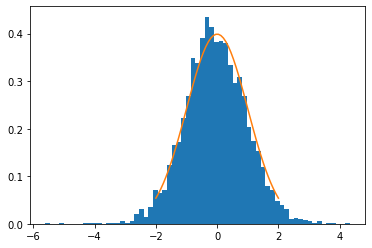

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import norm

Z, SE, TAU = simulation()
_ = plt.hist((np.array(TAU) - 10)/np.sqrt(np.var(TAU)), density=True, bins='auto')
x = np.linspace(-2,2)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulation2(n=5000):
    Z, SE, TAU = list(), list(), list()
    for i in range(n):
        po = PotentialOutcome(*get_data())
        result = po.est_via_aipw(OLS,LogisticRegression)
        z = result['z']
        se = result['Standard Error']
        Z.append(z)
        SE.append(se)
        TAU.append(result['Average Treatment Effect'])
    return Z, SE, TAU

Z2, SE2, TAU2 = simulation2()
_ = plt.hist((np.array(TAU2) - 10)/np.sqrt(np.var(TAU2)), density=True, bins='auto')
x = np.linspace(-2,2)
pdf = norm.pdf(x)
_ = plt.plot(x,pdf)
plt.show()